## Final Project Submission

Please fill out:
* Student name: Gabriel Araujo
* Student pace:part time
* Scheduled project review date/time: 10/10/20 @ 2:30 P.M
* Instructor name: James Irving
* Blog post URL:


# IMPORTING

Importing all necessary Classes for this project.

In [4]:
#IMPORTS
import pandas as pd
import datetime as dt
import xgboost as xgb
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
import warnings
from sklearn import metrics
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
import shap
warnings.filterwarnings('ignore')
%matplotlib inline
!jt -t monokai

Let's create blank variables for the model classifiers that we want to make

In [5]:
grid_clf = None
xgb_clf = None
forest_clf = None

# DATA

The dataset being analyzed in this project is called "Kickstarter dataset" and was taken from www.Kaggle.com. The main goal for this project is to create a model that can accurately predict if a startup will be successful and to give insights into how to make brand new startups flourish.

Now let's analyze the dataset in order to determine which features can be used as predictors.

In [6]:
pd.set_option('display.max_columns', None)
df = pd.read_csv('18k_Projects.csv',low_memory=False)
df

,Id,Name,Url,State,Currency,Top Category,Category,Creator,Location,Updates,Comments,Rewards,Goal,Pledged,Backers,Start,End,Duration in Days,Facebook Connected,Facebook Friends,Facebook Shares,Has Video,Latitude,Longitude,Start Timestamp (UTC),End Timestamp (UTC),Creator Bio,Creator Website,Creator - # Projects Created,Creator - # Projects Backed,# Videos,# Images,# Words (Description),# Words (Risks and Challenges),# FAQs
0,1007121454,Nail Art and Photos Printed on your Nails w/ E...,https://www.kickstarter.com/projects/137019948...,failed,USD,Art,Art,Dodie Egolf,Puyallup,0,0,9,20000,6,2,2013/12/15,2014/01/14,30,Yes,272.0,70,Yes,47.180395,-122.252903,2013/12/15 01:53:49.000,2014/01/14 01:53:49.000,https://www.kickstarter.com/profile/1370199487,NaN,1,0.0,0.0,2,297,153.0,0
1,2032015036,Cold Again,https://www.kickstarter.com/projects/737783165...,failed,USD,Film & Video,Short Film,James Jacobs,Boston,0,0,8,3000,180,5,2013/12/15,2014/01/17,33,Yes,573.0,57,Yes,42.332338,-71.045620,2013/12/15 02:30:01.000,2014/01/17 02:30:01.000,https://www.kickstarter.com/profile/737783165,NaN,1,4.0,0.0,0,276,98.0,0
2,733782855,Uchu Bijin Jewelry,https://www.kickstarter.com/projects/uchubijin...,failed,USD,Fashion,Fashion,Uchu Bijin,New York,1,2,17,5000,1941,62,2013/12/15,2014/01/14,30,No,NaN,158,No,40.706577,-73.882374,2013/12/15 01:29:42.000,2014/01/14 01:29:42.000,https://www.kickstarter.com/profile/858150887,http://uchubijin.com,2,2.0,0.0,12,1049,66.0,2
3,514687871,"Poetically Speaking: Stories of Love, Triumph ...",https://www.kickstarter.com/projects/tylicee/p...,failed,USD,Publishing,Poetry,Tylicee Mysreign,Detroit,0,0,4,5000,130,5,2013/12/15,2014/02/13,60,Yes,1285.0,2,Yes,42.354639,-83.102840,2013/12/15 01:12:28.000,2014/02/13 01:12:28.000,https://www.kickstarter.com/profile/1079088465,http://www.linkedin.com/pub/mys-reign/1a/469/4a8,1,2.0,0.0,0,309,169.0,0
4,683545993,Stranger Travels: Teachings from the Heart of ...,https://www.kickstarter.com/projects/197270300...,failed,USD,Publishing,Nonfiction,Ian Driscoll,Pucallpa,0,0,12,12000,1015,16,2013/12/15,2014/01/14,30,Yes,969.0,411,Yes,-8.433810,-74.559570,2013/12/15 01:17:46.000,2014/01/14 01:17:46.000,https://www.kickstarter.com/profile/1972703001,http://strangertravels.wordpress.com,1,0.0,0.0,6,1636,216.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18137,772170337,The dog sleeping bag that mates with your slee...,https://www.kickstarter.com/projects/140863402...,successful,USD,Design,Product Design,Andy Storms,Seattle,12,4,13,12000,12159,153,2014/04/11,2014/05/07,25,Yes,1306.0,0,Yes,NaN,NaN,2014/04/11 00:01:41.000,2014/05/07 00:00:00.000,https://www.kickstarter.com/profile/1408634020,NaN,2,8.0,0.0,7,229,86.0,1
18138,333919088,Kokua - Wanderlichter,https://www.kickstarter.com/projects/688493880...,successful,USD,Music,Music,David Matsumura,Los Gatos,6,1,14,7000,8296,156,2014/05/16,2014/06/15,30,Yes,2346.0,0,Yes,NaN,NaN,2014/05/16 05:13:04.000,2014/06/15 05:13:04.000,https://www.kickstarter.com/profile/688493880,NaN,2,1.0,0.0,0,123,50.0,0
18139,1856281681,The Awkward Yeti's Great Big Project - 3 Books...,https://www.kickstarter.com/projects/106395834...,successful,USD,Publishing,Children's Book,Nick Seluk,Detroit,14,35,23,18000,27621,459,2014/03/19,2014/04/18,30,Yes,316.0,0,Yes,NaN,NaN,2014/03/19 00:45:39.000,2014/04/18 00:45:39.000,https://www.kickstarter.com/profile/106395834,NaN,4,6.0,0.0,6,962,238.0,1
18140,1845568888,King James Version,https://www.kickstarter.com/projects/193669267...,failed,USD,Music,Music,James Jones,Atlanta,0,0,13,100000,45,1,2013/12/18,2014/01/17,30,Yes,1103.0,0,Yes,NaN,NaN,2013/12/18 00:23:48.000,2014/01/17 00:23:48.000,https://www.kickstarter.com/profile/1936692679,NaN,2,0.0,0.0,1,654,131.0,0


Right off the bat, it can be seen that some columns will not make good predictors and some columns will need to be engineered in order to make data useful.

Let's begin by dropping unneeded columns.

In [7]:
#DROPPING UNNEEDED COLUMNS
unneded_list = ['Id','Name','Url','Creator','Latitude','Longitude',
                'Start Timestamp (UTC)','End Timestamp (UTC)','Creator Bio',
                'Location','Currency']

df = df.drop(columns = unneded_list,axis = 1)

There are still some columns that do not seem too promising, but with some feature engineering, we can extract the most out of them.

In [8]:
#TURNING THE CREATOR WEBSITE COLUMN INTO A A BINARY HAS_CREATOR WEBSITE COLUMN
df['Has_Creator_Website'] = df['Creator Website'].isna()

#DROPPING THE CREATOR WEBSITE COLUMN
df = df.drop(columns='Creator Website',axis=1)

#SINCE THE AMOUNT PLEDGED HAS A DIRECT CORRELATION WITH A STARTUP'S SUCCESS/FAILURE
#A NEW COLUMN NAMED AVERAGE_PLEDGED_PER_BACKER WILL BE CREATED TO SEE IF THE 
#NUMBER OF BACKERS ALSO HAS A DIRECT CORRELATION WITH THE TARGET
df['Average_Pledge_per_Backer'] = df['Pledged']/df['Backers']

#DROPPING PLEDGED AND BACKERS COLUMNS
df = df.drop(columns=['Pledged','Backers'],axis=1)

#CHANGING START AND END DATES INTO DATETIME FORMATS
df['Start'] = pd.to_datetime(df['Start'])
df['End'] = pd.to_datetime(df['End'])

#EXTRACTING THE MONTHS
df['Start_Month'] = df['Start'].dt.month
df['End_Month'] = df['End'].dt.month

#DROPPING START AND END COLUMNS
df=df.drop(columns = ['Start','End'],axis=1).copy()



This is enough feature engineering for now, let's take a deeper look into the remaining features to see if some of them were formated wrong and to see how many null values there are in the dataset.

In [9]:
print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18142 entries, 0 to 18141
Data columns (total 23 columns):
State                             18142 non-null object
Top Category                      18142 non-null object
Category                          18142 non-null object
Updates                           18142 non-null int64
Comments                          18142 non-null int64
Rewards                           18142 non-null int64
Goal                              18142 non-null int64
Duration in Days                  18142 non-null int64
Facebook Connected                18142 non-null object
Facebook Friends                  12290 non-null float64
Facebook Shares                   18142 non-null int64
Has Video                         18142 non-null object
Creator - # Projects Created      18142 non-null int64
Creator - # Projects Backed       13898 non-null float64
# Videos                          18041 non-null float64
# Images                          18142 non-null int64


,State,Top Category,Category,Updates,Comments,Rewards,Goal,Duration in Days,Facebook Connected,Facebook Friends,Facebook Shares,Has Video,Creator - # Projects Created,Creator - # Projects Backed,# Videos,# Images,# Words (Description),# Words (Risks and Challenges),# FAQs,Has_Creator_Website,Average_Pledge_per_Backer,Start_Month,End_Month
0,failed,Art,Art,0,0,9,20000,30,Yes,272.0,70,Yes,1,0.0,0.0,2,297,153.0,0,True,3.000000,12,1
1,failed,Film & Video,Short Film,0,0,8,3000,33,Yes,573.0,57,Yes,1,4.0,0.0,0,276,98.0,0,True,36.000000,12,1
2,failed,Fashion,Fashion,1,2,17,5000,30,No,NaN,158,No,2,2.0,0.0,12,1049,66.0,2,False,31.306452,12,1
3,failed,Publishing,Poetry,0,0,4,5000,60,Yes,1285.0,2,Yes,1,2.0,0.0,0,309,169.0,0,False,26.000000,12,2
4,failed,Publishing,Nonfiction,0,0,12,12000,30,Yes,969.0,411,Yes,1,0.0,0.0,6,1636,216.0,0,False,63.437500,12,1


The dataset has some issues. There are columns with null values and other's would be more useful if they were bool.

Let's take it step-by-step and begin with columns that we want to be bool.

Columns such as 'Has Video' and 'Facebook Connected' could be more useful if the data in them were binary (0 or 1). 

In [10]:
#CHANGING THE HAS VIDEO COLUMN INTO BINARY
df['Has Video']= df['Has Video'].replace({'Yes':True,'No':False})

#CHANGING THE FACEBOOK CONNECTED COLUMN INTO BINARY
df['Facebook Connected'] = df['Facebook Connected'].replace({'Yes':True,'No':False})

With that out of the way, we can look at our null values. In order to make a successful model, all null values have to be removed or filled in.

In [11]:
df.isna().sum()

State                                0
Top Category                         0
Category                             0
Updates                              0
Comments                             0
Rewards                              0
Goal                                 0
Duration in Days                     0
Facebook Connected                   0
Facebook Friends                  5852
Facebook Shares                      0
Has Video                            0
Creator - # Projects Created         0
Creator - # Projects Backed       4244
# Videos                           101
# Images                             0
# Words (Description)                0
# Words (Risks and Challenges)     101
# FAQs                               0
Has_Creator_Website                  0
Average_Pledge_per_Backer            0
Start_Month                          0
End_Month                            0
dtype: int64

Facebook Friends feature has a lot of missing values, let's try to figure out why that is

In [12]:
df.loc[(df['Facebook Connected'] == False),['Facebook Connected','Facebook Friends']]

,Facebook Connected,Facebook Friends
2,False,NaN
6,False,NaN
12,False,NaN
15,False,NaN
20,False,NaN
...,...,...
18127,False,NaN
18129,False,NaN
18130,False,NaN
18131,False,NaN


It appears like all the startups that are not Facebook connected have null values for the number of Facebook friends. Let's confirm if the number of NaN matches the number of startups that are not Facebook Connected.

In [13]:
print(f'Number of Missing in Facebook Friends: {df["Facebook Friends"].isna().sum()}''\n')

print('Is Facebook Connected? \n',df['Facebook Connected'].value_counts())

Number of Missing in Facebook Friends: 5852

Is Facebook Connected? 
 True     12290
False     5852
Name: Facebook Connected, dtype: int64


Since both numbers matches, let's fill all null values in Facebook Friends with 0 because you cannot have Facebook firends if you are not connected to Facebook.

In [14]:
df['Facebook Friends'].fillna(0,inplace=True)

Let's look at how our data looks after our changes.

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18142 entries, 0 to 18141
Data columns (total 23 columns):
State                             18142 non-null object
Top Category                      18142 non-null object
Category                          18142 non-null object
Updates                           18142 non-null int64
Comments                          18142 non-null int64
Rewards                           18142 non-null int64
Goal                              18142 non-null int64
Duration in Days                  18142 non-null int64
Facebook Connected                18142 non-null bool
Facebook Friends                  18142 non-null float64
Facebook Shares                   18142 non-null int64
Has Video                         18142 non-null bool
Creator - # Projects Created      18142 non-null int64
Creator - # Projects Backed       13898 non-null float64
# Videos                          18041 non-null float64
# Images                          18142 non-null int64
# Wo

There are some null values in the '# Videos' columns, so let's drop them all since the number of null rows are so small.

In [16]:
df = df[df['# Videos'].notna()].copy()

"Creator - # Projects Backed" feature has a lot of missing values as well, but since we will fill out the missing values later, let's make a "Was_missing_#_Projects_Backed" feature just to see if missing that info impacted the model or not.

In [17]:
df['Was_missing_#_Projects_Backed'] = df['Creator - # Projects Backed'].isna()

Let's take a last look at the dataset info

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18041 entries, 0 to 18141
Data columns (total 24 columns):
State                             18041 non-null object
Top Category                      18041 non-null object
Category                          18041 non-null object
Updates                           18041 non-null int64
Comments                          18041 non-null int64
Rewards                           18041 non-null int64
Goal                              18041 non-null int64
Duration in Days                  18041 non-null int64
Facebook Connected                18041 non-null bool
Facebook Friends                  18041 non-null float64
Facebook Shares                   18041 non-null int64
Has Video                         18041 non-null bool
Creator - # Projects Created      18041 non-null int64
Creator - # Projects Backed       13797 non-null float64
# Videos                          18041 non-null float64
# Images                          18041 non-null int64
# Wo

Everything looks good, so let's move into modeling.

# BASELINE MODEL (RANDOM FOREST)

Now we are going to make a model using the Random Forest Classifier. First let's split our data into our target (y) and predictors (X). We will also split our data into our train and test sets.

In [19]:
#SPLITTING DATA INTO X AND Y.
y = df['State'].copy()
X = df.drop(columns = 'State',axis = 1).copy()

#USING PANDAS GET DUMMIES TURN ALL CATEGORIAL COLUMNS INTO BINARY
X = pd.get_dummies(X)

#DOING TRAIN-TEST SPLIT
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.2,random_state = 69)

#GETTING THE IMPUTER TO FILL NULL VALUES IN THE 'CREATOR - # PROJECTS BACKED'
#WITH THE MEAN VALUE
imputer = SimpleImputer(strategy='mean')

#FILLING THE NULL VALUES IN X_TRAIN AND X_TEST USING THE IMPUTER
X_train = imputer.fit_transform(X_train)
X_test = imputer.transform(X_test)

#SCALLING ALL DATA
# scaler = StandardScaler()
# scaled_X_train = scaler.fit_transform(X_train)
# scaled_X_test = scaler.transform(X_test)

#PRITTING VALUE COUNTS OF TARGET COLUMN TO SEE IF DATA IS BALANCED
y_test.value_counts(normalize=True)

failed        0.510391
successful    0.489609
Name: State, dtype: float64

Since we plan on making multiple models, let's make a function to make our job easier.

In [20]:
def model_eval(model,X_train,y_train,X_test,y_test,classes=None,
                           normalize='true',cmap='Blues',label=''):

    #FITTING MODEL WITH TRAIN DATA
    model.fit(X_train,y_train)   
      
    #GETTING TRAIN PREDICTIONS
    y_hat_train = model.predict(X_train)
    
    #GETING TEST PREDICTIONS
    y_hat_test = model.predict(X_test)
    
    dashes = '---'*20
    
    if model == grid_clf:
        grid_header = "GRID SEARCH FOUND THE FOLLOWING OPTIMAL PARAMETERS: "
        print(dashes,grid_header,dashes,sep='\n')        
        for param_name in sorted(best_parameters.keys()):
            print("%s: %r" % (param_name, best_parameters[param_name]))
    
    #GETTING ACCURACY SCORE FOR TRAIN AND TEST
    
    if len(label)>0:
        accuracy_header = f'{label} ACCURACY'
    else:
        accuracy_header = 'MODEL ACCURACY'
    print(dashes,accuracy_header,dashes,sep='\n')
    training_accuracy = accuracy_score(y_train, y_hat_train)
    testing_accuracy = accuracy_score(y_test, y_hat_test)
    
    print(f'TRAINING ACCURACY: {round(training_accuracy*100,2)}%')
    print(f'TESTING ACCURACY: {round(testing_accuracy*100,2)}%')
          
    #CLASSIFICATION REPORT AND SCORES
    test_header = "CLASSIFICATION REPORT"
    
    #ADDING LABEL IF GIVEN
    if len(label)>0:
        test_header += f" USING {label}"
    
    # PRINT CLASSIFICATION REPORT
    
    print(dashes,test_header,dashes,sep='\n')

    print(metrics.classification_report(y_test,y_hat_test,
                                    target_names=classes))

    print(dashes+"\n\n")
    
    

    # MAKE FIGURE
    fig, axes = plt.subplots(figsize=(10,4),ncols=2)
    
    # PLOTTING CONFUSION MATRIX 
    metrics.plot_confusion_matrix(model, X_test,y_test,
                                  display_labels=classes,
                                  normalize=normalize,
                                 cmap=cmap,ax=axes[0])
    axes[0].set(title='Confusion Matrix')
    
    #PLOTTING ROC CURVE
    roc_plot = metrics.plot_roc_curve(model, X_test, y_test,ax=axes[1])
    axes[1].legend()
    axes[1].plot([0,1],[0,1],ls=':')
    axes[1].grid()
    axes[1].set_title('Receiving Operator Characteristic (ROC) Curve') 
    fig.tight_layout()
    plt.show()

   

Let's make a Vanilla Random Forest model to see how it performs.

------------------------------------------------------------
RANDOM FOREST ACCURACY
------------------------------------------------------------
TRAINING ACCURACY: 100.0%
TESTING ACCURACY: 87.34%
------------------------------------------------------------
CLASSIFICATION REPORT USING RANDOM FOREST
------------------------------------------------------------
              precision    recall  f1-score   support

      failed       0.91      0.84      0.87      1842
  successful       0.84      0.91      0.88      1767

    accuracy                           0.87      3609
   macro avg       0.88      0.87      0.87      3609
weighted avg       0.88      0.87      0.87      3609

------------------------------------------------------------




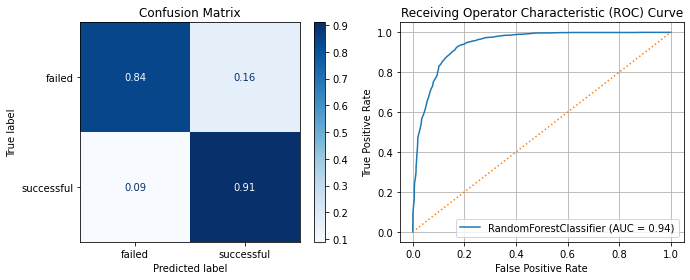

In [21]:
forest_clf = RandomForestClassifier()
model_eval(forest_clf,X_train,y_train,X_test,y_test,label='RANDOM FOREST')

The vanilla Random Forest over-fitted the data, causing the training accuracy to be 100%, but the test accuracy wasn't too bad at 87.28%. What is really important in a classification model is the Receiving Operator Characteristic Curve, the higher the value, the better, with a 1.0 giving perfect predictions. For this Vanilla model, the ROC Curve is 0.94, which is pretty good as well. Let's try using a different model to see if that score can be improved.

# MODEL IMPROVEMENT (VANILLA XGBOOST)

XGBoost (eXtreme Gradient Boosting) is an advanced implementation of gradient boosting algorithm. XGBoost implements parallel processing which causes it to be much faster than other boosting techniques. Let's make a Vanilla XGBoost model to see how it performs.  

------------------------------------------------------------
XGBOOST ACCURACY
------------------------------------------------------------
TRAINING ACCURACY: 90.67%
TESTING ACCURACY: 89.64%
------------------------------------------------------------
CLASSIFICATION REPORT USING XGBOOST
------------------------------------------------------------
              precision    recall  f1-score   support

      failed       0.93      0.86      0.89      1842
  successful       0.86      0.94      0.90      1767

    accuracy                           0.90      3609
   macro avg       0.90      0.90      0.90      3609
weighted avg       0.90      0.90      0.90      3609

------------------------------------------------------------




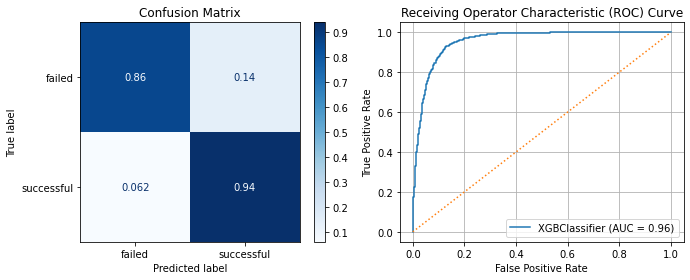

In [22]:
xgb_clf = xgb.XGBClassifier()
model_eval(xgb_clf,X_train,y_train,X_test,y_test,label='XGBOOST')

The vanilla XGBoost model did not over-fit the data like the Random Forest model.The training accuracy dropped to 90%, but the testing accuracy went up by 2.5%. The ROC Curve went up to 0.96 compared to 0.94. Let's try some hyperparameter tuning to see if the if we can make the model even better.

# TUNING XGBOOST MODEL USING GRIDSEARCH

GridSearch makes it extremely easy to try different parameter values. First, let's make a dictionary with the parameters we want to tune and their values. 

In [23]:
#PARAMETERS DICTIONARY FOR GRIDSEARCH
param_grid = {
    "learning_rate": [0.1,0.01],
    'max_depth': [3,6,9],
    'min_child_weight': [1,3,5],
    'subsample': [0.6,0.7],
    'n_estimators': [100,250,450],
}

In [24]:
# grid_clf = GridSearchCV(xgb_clf, param_grid, scoring='accuracy', cv=3, n_jobs=3)
# model_eval(grid_clf,X_train,y_train,X_test,y_test,
#            label='GRIDSEARCH XGBOOST')

# RESULTS USING SHAP

Now that the model has been tuned, let's look at the most important features and what they mean.
First, since the 'X_train' is an array, let's make it into a DataFrame.

In [25]:
X_train = pd.DataFrame(X_train,columns = X.columns)

Now, since SHAP does not take GridSearch, we will fit a XGBoost model with the best hypertuning parameters. Then let's get the SHAP values.

In [26]:
#CALLING THE XGBOOST CLASSIFIER WITH BEST PARAMETERS
final_clf = xgb.XGBClassifier(learning_rate= 0.1,max_depth= 3,
                              min_child_weight= 1,n_estimators= 450,
                              subsample= 0.7)
#FITTING THE XGBOOST MODEL
final_clf.fit(X_train,y_train)

#CALLING SHAP TREE EXPLAINER
explainer = shap.TreeExplainer(final_clf)

#GETTING SHAP VALUES
shap_values = explainer.shap_values(X_train)

#INITIATING SHAP
shap.initjs()

Now that we have the SHAP Values, we can start making some plots!

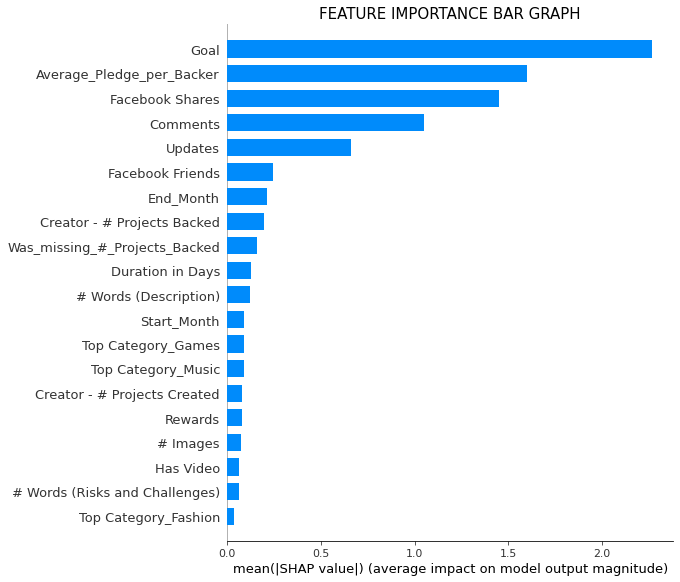

In [27]:
#PLOTTING MOST IMPORTATANT FEATURES
shap.summary_plot(shap_values, X_train, plot_type="bar", show=False)
plt.title('FEATURE IMPORTANCE BAR GRAPH',fontsize = 15)
plt.show()

The plot above illustrates the top 20 important features in our model, with 'Goal' being the feature that was used the most to split the XGBoost tree. By looking at the graph itself, it is impossible to know the impact of the features.Goal could be the most important, but it's not known if beneficial to have a large or small goal. This is where the regular SHAP summary_plot comes in.

The SHAP summary plot can further show the positive and negative relationships of the predictors with the target variable.
This plot is made of all the dots in the train data. It demonstrates the following information:
- Feature importance: Variables are ranked in descending order.
- Impact: The horizontal location shows whether the effect of that value is associated with a higher or lower prediction.
- Original value: Color shows whether that variable is high (in red) or low (in blue) for that observation.

(Dr. Dataman - towardsdatascience.com)

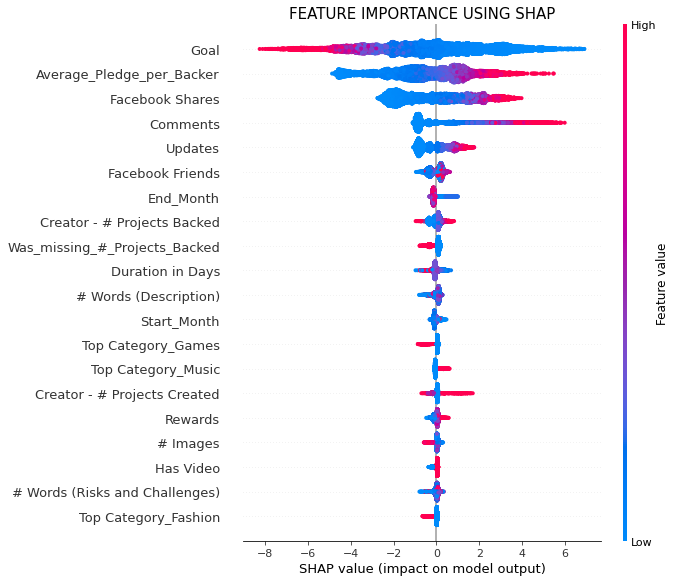

In [28]:
shap.summary_plot(shap_values,X_train,show=False)
plt.title('FEATURE IMPORTANCE USING SHAP',fontsize = 15)
plt.show()


The following conclusions can be taken from the plot above.

Things that increase a Startup's success rate:
- The more money an individual backer gives, the higher the chance of success.The number of individual backers isn't as important.
- The more marketing and social media exposure/involvement (Number of Facebook shares and comments) the better.
- High number of projects created. An experienced entrepreneur has a higher chance than an amateur.
- The more rewards the better.

Things that decrease a Startup's success rate:
- The higher the Goal, the lower the chance of a startup being successful.
- Long duration Campaigns.
- Campaigns that end close to the end of the year.
- Games and Fashion Categories.




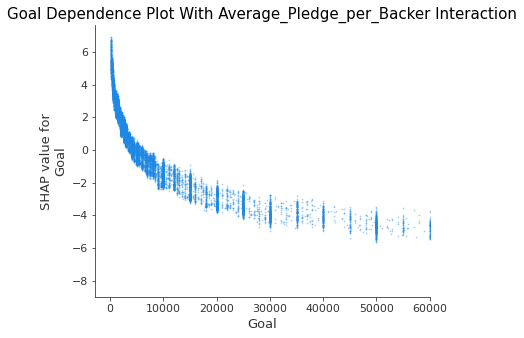

In [29]:
shap.dependence_plot('Goal',shap_values,features=X_train,xmax="percentile(95)",
                    alpha=0.4,dot_size=3,interaction_index=None,
                    show=False,)
plt.title('Goal Dependence Plot With Average_Pledge_per_Backer Interaction',fontsize = 15)
plt.show()

After taking a closer look into the 'Goal Dependence Plot With Average_Pledge_per_Backer Interaction', it can be clearly seen how high goals negatively impacts the model's output. A good goal limit for a campaign is around $10,000.00.  

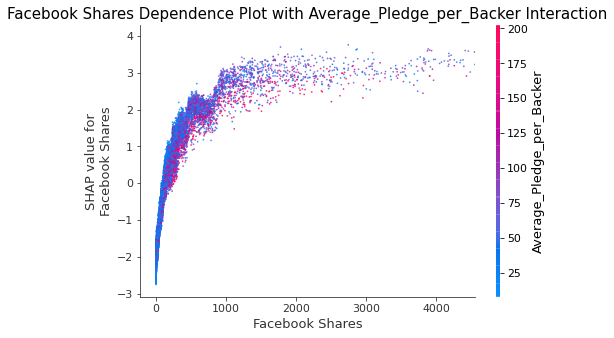

In [30]:
shap.dependence_plot('Facebook Shares',shap_values,features=X_train,xmax="percentile(99)",
                    alpha=0.8,dot_size=3,interaction_index="Average_Pledge_per_Backer",
                    show=False,)
plt.title('Facebook Shares Dependence Plot with Average_Pledge_per_Backer Interaction',fontsize = 15)
plt.show()

This other Facebook Shares dependence plot shows how a large number of shares positively impacts the model's output. It can also be seen how a high number of shares also affects the Average amount pledged per backer. The more exposure in the social media, the more money the backers are willing to pledge into the startup.

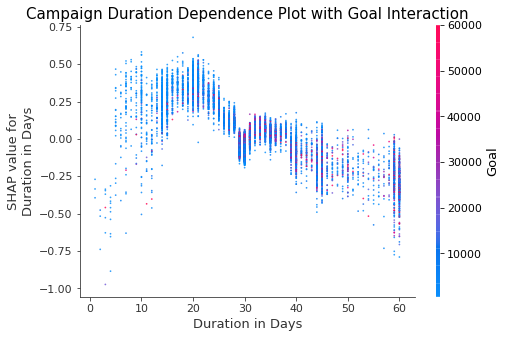

In [31]:
shap.dependence_plot('Duration in Days',shap_values,features=X_train,
                    alpha=0.8,dot_size=3,interaction_index="Goal",
                    show=False,)
plt.title('Campaign Duration Dependence Plot with Goal Interaction',fontsize = 15)
plt.show()

In [37]:
print(df[(df['State']=='successful') & (df['Goal']<= 10000)].shape)
print(df[(df['State']=='successful') & (df['Goal']> 10000)].shape)

(7103, 24)
(1885, 24)


# CONCLUSION AND FUTURE WORK

## Conclusion

After analyzing the SHAP summary and dependence plots, the following conclusions were taken.

If you are a creator looking to start your own startup in Kickstarter, look for the following pointers:

- Set a small goal for your campaign. Historically, campaigns that had a small goal were more successful. Limit your goal to $10,000.


- The more marketing and social media exposure/involvement (Number of Facebook shares and comments) the better. The higher number of people who are exposed to your idea or product, the higher the chance to get individual to take an interest and invest in it. 


- Focus on a niche and target that specific audience. Some campaigns are successful not because they had a big number of backers, but because those backers like the idea so much that they decided to invest a lot into it.


- Do not give up on your first project/campaign, the more campaigns you do, the more you will learn from them and the higher will be your success rate on the next one.


- Pick a campaign duration of between 10 to 30 days. Data shows that the success rate of campaigns with duration longer than 30 days drops drastically.


- Do not make your campaign's end date close to the end of the year. Success rate may tends to decrease during that time because people might be saving money for the holidays.


- Try to have a reward system. People might invest more money into your project if they get an 'immediate' return from it.


- Avoid Games and Fashion categories. Those markets might be too saturated, and your project might just fall through the cracks.

## Future Work

- Do more research into the reason behind the increased failure rate of long campaigns. Does the Kickstarter algorithm only focus on fresh projects?


- Determine the best reward system to have in a campaign. Is it better to have a discount tier, give brand merchandise and souvenirs, or give out product prototypes?


- Prove the end date hypothesis correct. 